## Лабораторная работа 2

#### Явная и неявная ***конечно-разностные крест схемы***. Решение начально краевых задач для уравнений **гиперболического** типа.

вариант 4

***Уравнение:***

$$\displaystyle\frac{\partial^2 u}{\partial t^2} =  \displaystyle\frac{\partial^2 u}{\partial x^2} -5 u $$

***Граничные условия:***

\begin{equation*}
 \begin{cases}
   u_{x}' (0, \: t) = 2u(0, t)
   \\
   u_{x}' (1, \: t) =  2u(1, t)
   \\
   u(x, \: 0) = \psi_1(x) = e^{2x}
   \\
   u_{t}(x, 0) = \psi_2(x) = 0
 \end{cases}
\end{equation*}

***Аналитическое решение:***
$$u(x, t) = e^{2x} \cos{t}$$

In [1]:
from math import pi, sin, exp, log, cos, sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Гиперкласс для основных методов

In [56]:
class Data:
    def __init__(self, t_max = 1, x_max = 1, x=10, t=7):
        self.x_diap = np.linspace(0, x_max, endpoint=True, num=x)
        self.t_diap = np.linspace(0, t_max, endpoint=True, num=t)
        self.x = x
        self.t = t
        self.dt = (t_max - 0) / t
        self.dx = (x_max - 0) / x 
        self.q = (self.dt) / (self.dx)**2 # dt / dx^2
        self.sigma = (self.dt)**2 / (self.dx)**2 # dt^2 / dx^2
        # считаем начальную матрицу первую строчку заполняем начальными условиями остальное None
        self.U = [[exp(2 * self.x_diap[i]) for i in range(self.x)]] + [[None for i in range(self.x)] for j in range(self.t-1)]
        
    def d(self): # показывает матрицу U
        df = pd.DataFrame(np.array(self.U), columns=self.x_diap, index=self.t_diap)
        print(df, df.shape)
        
    def d2x(self, x, t): # считает второую производную по иксам в точке
        return (self.U[t][x+1] - 2 * self.U[t][x] + self.U[t][x-1]) / self.dx**2
    
    def display(self, title): # показывает получившийся + правильный графики решения
        fig, axs = plt.subplots(1, 2,figsize=(20,6))
        fig.suptitle(title)
        for i, row in enumerate(self.U):
            axs[0].plot(row, label="t={:.3f}".format(self.t_diap[i]))
        for t in self.t_diap:
            axs[1].plot([exp(2 * x) * cos(t) for x in self.x_diap])
        fig.legend()
        
    def err(self): # считает MSE между результатом в матрице и правильным решением
        my = self.U[-1]
        real = [exp(2 * j) * cos(self.t_diap[-1]) for j in self.x_diap]
        return sqrt(sum([(i - j)**2 for i, j in zip(my, real)]))
    
    def allErr(self):
        f = lambda x,t: exp(2*x)*cos(t)
        real = [[f(x,t) for x in self.x_diap] for t in self.t_diap]
        all = []
        for t in range(len(self.t_diap)):
            s = 0
            for x in range(len(self.x_diap)):
                s += (real[t][x] - self.U[t][x])**2
            all.append(s**(1/2))
        return sum(all)**(1/2)
    
    def error(self, steps):
        plt.figure(figsize=(20, 6))
        plt.suptitle('Ошибка в зависимости от шага')
        for j in [5,7,10,15,25,35]:
            errA = []
            for i in steps[::-1]:
                d = CrankNicolson(x=i, t_max=j, t=20)
#                 change that
#                 real = [exp(-self.a * self.t_diap[::-1][0]) * sin(x) for x in d.x_diap]
                d.fit()
                errA.append(sum([abs(real[j] - d.U[::-1][0][j])**2 for j in range(len(real))])**0.5)
            plt.plot(steps, errA, label=f"t={j}")
        plt.legend()

### Явная конечно-разностная схема

Апроксимируем вторую производную по значениям нижнего временного слоя $t^k$, а именно:

$$\displaystyle\frac{\partial^2 u}{\partial x^2}(x_j, t^k) = \displaystyle\frac{u^k_{j-1} - 2 u^k_{j} + u^k_{j+1}}{h^2}$$

Тогда получим явную схему конечно-разностного метода во внутренних узлах сетки:

$$\displaystyle\frac{u^{k+1}_j - 2u^k_j + u_j^{k-1}}{\tau^2} = \displaystyle\frac{u^k_{j-1} - 2 u^k_{j} + u^k_{j+1}}{h^2} - 5u_j^k, \; \forall j \in \{1, ..., N-1\}, \forall k \in \{0, ..., K-1\}$$

Обозначим $\sigma = \displaystyle\frac{\tau^2}{h^2}$, тогда:

$$u^{k+1}_j = \sigma (u^k_{j+1} - 2 u^k_j + u^k_{j-1}) - 5\tau^2 u^k_j + 2u^k_j - u^{k-1}_j$$

Граничные же значения $u^{k+1}_0$ и $u^{k+1}_N$ определяются граничными условиями $u_x(0, t)$ и $u_x(l, t)$ при помощи апроксимации производной.

In [57]:
class ExplicitScheme(Data):
    def GridSearch(self, x, t):
        best_err, best_estimator = 10**100, {'x':None, 't':None}
        for i in t:
            for j in x:
                data = ExplicitScheme(x=j, t=i)
                data.fit()
                err = data.err()
                if err < best_err:
                    best_err, best_estimator = err, {'x':j, 't':i}
        return best_estimator, best_err
                
    def fit(self, method = "3 dots"): # может быть 2 dots или 3 dots для разных апроксимаций второй производной
        
        self.U[1] = [0] + [(self.d2x(j, 0) - 5 * self.U[0][j]) * self.dt**2 + self.U[0][j] for j in range(1, self.x - 1)] + [0]
        self.U[1][0] = self.U[1][1] / (1 + 2 * self.dx)
        self.U[1][-1] = self.U[1][-2] / (1 - 2 * self.dx)
        
        for i in range(2, self.t):
            self.U[i] = [0] + [(self.d2x(j, i-1) - 5 * self.U[i-1][j]) * self.dt**2 - self.U[i-2][j] + 2 * self.U[i-1][j] for j in range(1, self.x - 1)] + [0]
            self.U[i][0] = self.U[i][1] / (2 * self.dx + 1)
            self.U[i][-1] = (2 * self.dx + 1) * self.U[i][-2]

In [58]:
data = ExplicitScheme(x=120, t=3)
data.fit()
# data.d()
data.GridSearch(range(5, 200), range(3, 20))

({'x': 5, 't': 12}, 1.0656900841029553)

In [59]:
data = ExplicitScheme(x=120, t=3)
data.fit()

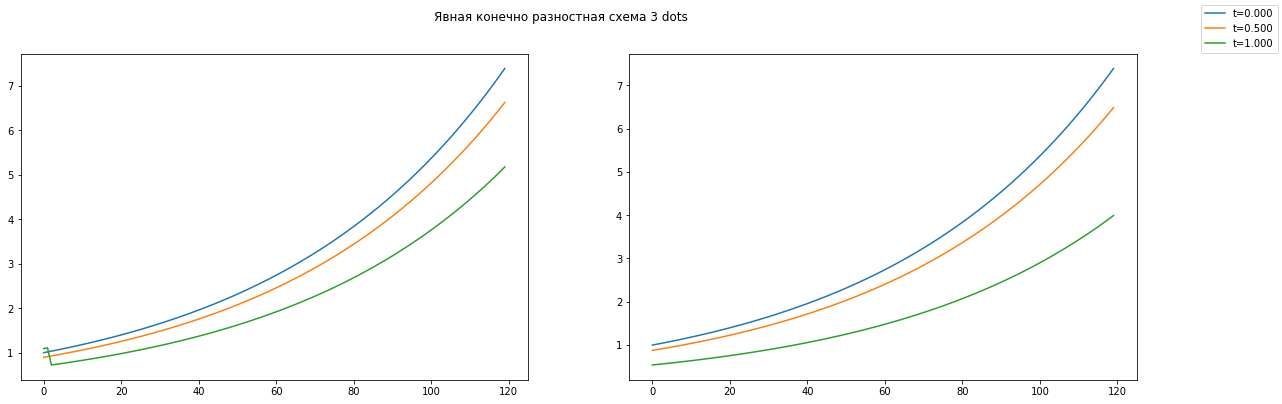

In [60]:
data.display('Явная конечно разностная схема 3 dots')

In [61]:
data.allErr()

2.6894506198346986

### Метод прогонки

In [62]:
def solveTD(m, b):
    y = [None] * len(m)
    alpha = [None] * len(m)
    beta = [None] * len(m)
    for i in range(len(m)):
        if i == 0:
            y[i] = m[i][0]
            alpha[i] = -1 * m[i][1] / y[i]
            beta[i] = b[i] / y[i]
        elif i == len(m) - 1:
            y[i] = m[i][1] + m[i][0] * alpha[i-1]
            beta[i] = (b[i] - m[i][0] * beta[i-1]) / y[i]
        else:
            y[i] = m[i][1] + m[i][0] * alpha[i-1]
            alpha[i] = -1 * m[i][2] / y[i]
            beta[i] = (b[i] - m[i][0] * beta[i-1]) / y[i]
    x = [0] * len(m)
    for i in range(len(m)):
        if i == 0:
            x[len(m)-i-1] = beta[len(m)-i-1]
        else:
            x[len(m)-i-1] = alpha[len(m)-i-1] * x[len(m)-i] + beta[len(m)-i-1]
    return x

### Неявная конечно-разностная схема

Апроксимируем вторую производную по значениям верхнего временного слоя $t^{k+1}$, а именно:

$$\displaystyle\frac{\partial^2 u}{\partial x^2}(x_j, t^k) = \displaystyle\frac{u^{k+1}_{j-1} - 2 u^{k+1}_{j} + u^{k+1}_{j+1}}{h^2}$$

Тогда получим явную схему конечно-разностного метода во внутренних узлах сетки:

$$\displaystyle\frac{u^{k+1}_j - 2u^k_j + u^{k-1}_j}{\tau^2} =  \displaystyle\frac{u^{k+1}_{j-1} - 2 u^{k+1}_{j} + u^{k+1}_{j+1}}{h^2} - 5u^{k+1}_j, \; \forall j \in \{1, ..., N-1\}, \forall k \in \{0, ..., K-1\}$$

Обозначим $\sigma = \displaystyle\frac{\tau^2}{h^2}$. Тогда значения функции на слое можно найти эффективны образом с помощью методом прогонки, где **СЛАУ**, кроме крайних двух уравнений, определяется коэффицетнами $a_j = 1$, $b_j = -(2 + 5h^2 + \displaystyle\frac{1}{\sigma})$, $c_j = 1$, $d_j = \displaystyle\frac{-2u^k_j + u^{k-1}_j}{\sigma}$ уравнений:

$$a_j u^{k+1}_{j - 1} + b_j u^{k+1}_j + c_j u^{k+1}_{j+1} = d_j, \; \forall j \in \{1, ..., N-1\}$$

Первое и последнее уравнение системы содержащие $u^{k+1}_0$ и $u^{k+1}_N$ определяются граничными условиями при помощи апроксимации производной.

*Неявная схема является абсолютно устойчивой*.

In [73]:
class NonExplicitScheme(Data):
    def GridSearch(self, x, t):
        best_err, best_estimator = 10**100, {'x':None, 't':None}
        for i in t:
            for j in x:
                data = NonExplicitScheme(x=j, t=i)
#                 data.prefit()
                data.fit()
                err = data.allErr()
                if err < best_err:
                    best_err, best_estimator = err, {'x':j, 't':i}
        return best_estimator, best_err
    
    def prefit(self):
        self.U[1] = [0] + [(self.d2x(j, 0) - 5 * self.U[0][j]) * self.dt**2 + self.U[0][j] for j in range(1, self.x - 1)] + [0]
        self.U[1][0] = self.U[1][1] / (2 * self.dx + 1)
        self.U[1][-1] =  self.U[1][-2] / (-2 * self.dx + 1)
        
    def fit(self, method = "3 dots"):
#         может быть 2 dots или 3 dots для разных апроксимаций второй производной
#         составляем трехдиагональную матрицу решаем получаем новые значения температур, вписываем их в матрицу
        
        self.U[1] = [0] + [(self.d2x(j, 0) - 5 * self.U[0][j]) * self.dt**2 + self.U[0][j] for j in range(1, self.x - 1)] + [0]
        self.U[1][0] = self.U[1][1] / (2 * self.dx + 1)
        self.U[1][-1] =  self.U[1][-2] / (-2 * self.dx + 1)
        
        for i in range(1, self.t-1):
            M = [[(1+2*self.dx),-1]] + \
            [[1, -(2+5*self.dx**2+ 1/self.sigma), 1] for i in range(1, self.x - 1)] \
            + [[-1,(1-2*self.dx)]]
            
            B = [0] + \
            [(-2 * self.U[i][j] + self.U[i-1][j]) / self.sigma for j in range(1, self.x - 1)] \
            + [0]
            
            for idx,item in enumerate(solveTD(M,B)):
                self.U[i+1][idx] = item
                
#             self.U[i+1][0] = self.U[i+1][1] / (1 + 2 * self.dx)
#             self.U[i+1][-1] =  self.U[i+1][-2] / (1 - 2 * self.dx)

In [64]:
data = NonExplicitScheme(x=5, t=5)
# data.prefit()
data.fit("3 dots")
data.GridSearch(range(5, 100), range(3, 20))

({'x': 26, 't': 3}, 2.39505673325875)

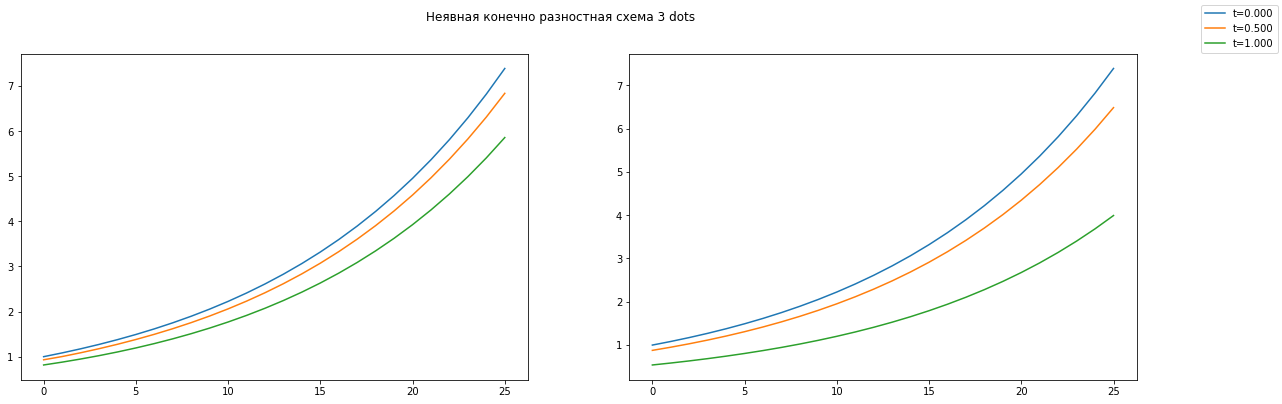

In [71]:
data = NonExplicitScheme(x=26, t=3)
# data.prefit()
data.fit()
data.display('Неявная конечно разностная схема 3 dots')

In [72]:
data.allErr()

2.39505673325875

In [80]:
e = []
for i in range(10,100):
    data = NonExplicitScheme(x=i, t=3)
    data.fit()
    e.append(data.err())

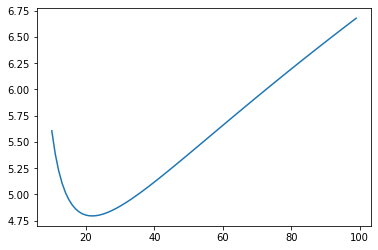

In [81]:
plt.plot(range(10,100), e)